# Project Description

This project offers hands-on experience in Machine Learning (ML) through the task of image classification. The primary goal is to classify images of Muslim shikhs using multiple ML algorithms, including logistic regression, decision tree, random forest, and support vector machines.

***Notes***
- The images of shikhs were collected automatically using the Python icrawler package. From an ethical standpoint, only publicly available images of well-known figures were used. The dataset targets a specific group of shikhs for educational purposes only and is not intended to generalize to all shikhs worldwide.

- Face and eye detection within the images was carried out using the Haar Cascade algorithm. [citation]



***الله المستعان***

### Sections in the notebook
* [Importing Packages](#Importing-Packages)
* [Data Cleaning](#Data-Cleaning)
* [Feature Engineering](#Feature-Engineering)
* [Model Development Process](#Model-Development-Process)

## Importing Packages

In [ ]:
# File and image Managing libraries
import os
from PIL import Image
import cv2
import shutil
import pywt

# Data viz 
import matplotlib.pyplot as plt
%matplotlib inline

# Data processing
import numpy as np
import pandas as pd


# Model building and evaluation packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


import pickle
import json

---
---

## Data Cleaning

In this phase, we will use the `OpenCV` library to load and process the images. Then, we will apply the `Haar Cascade` algorithm to detect faces in the images. This step helps filter out images with unclear or missing views of the shikh's face. Finally, the detected face regions will be saved in a designated data folder for use in the upcoming model-building phase.

In [2]:
# Important Configurations 

# Define the face and eye detection classifiers using OpenCV's pre-trained Haar cascades
face_cascade = cv2.CascadeClassifier('utilities/opencv_cascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('utilities/opencv_cascades/haarcascade_eye.xml')

# Define paths to the data
path_to_images = 'data/images'
path_to_faces = 'data/__faces/'

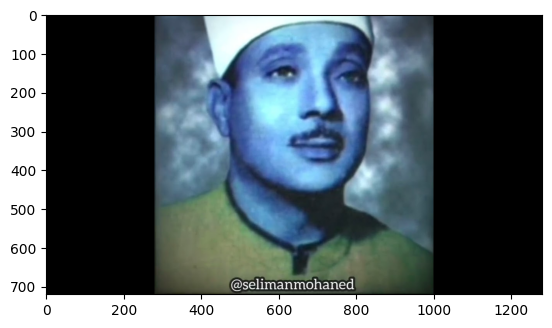

In [3]:
# Plotting an image
img_path = path_to_images + '/abdelbaset/000017.jpg'
img = cv2.imread(img_path)
plt.imshow(img);

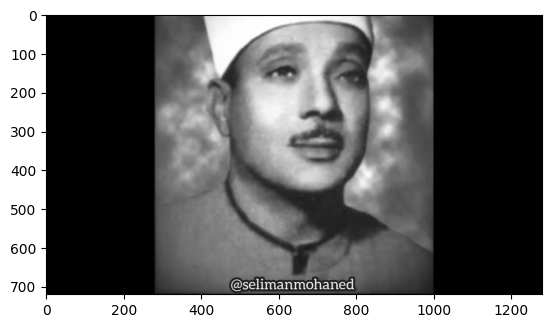

In [4]:
# The gray scale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img, cmap = 'gray');

In [5]:
# Getting the shikh folders
img_dirs = []
for entry in os.scandir(path_to_images):
    if entry.is_dir():
        img_dirs.append(entry)
img_dirs

[<DirEntry 'abdelbaset'>,
 <DirEntry 'alaa'>,
 <DirEntry 'banaa'>,
 <DirEntry 'hossary'>,
 <DirEntry 'meshary'>]

In [6]:
for img_dir in img_dirs:
    print(img_dir.name)

abdelbaset
alaa
banaa
hossary
meshary


In [7]:
# Create the faces folder
# if os.path.exists(path_to_faces):
#     shutil.rmtree(path_to_faces)
# os.mkdir(path_to_faces)

In [8]:
# Define a function to extract the faces from the images
def get_face(image_path):
    '''
    The functions captures the face of a given character image

    Args:
        image_path (str): The path to the image

    Returns:
        roi_color (np.array(m_pixles, n_pixles, 3)): The region of interest (the face)
    '''
    # Reading the image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detecting the face region
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y: y+h, x:x+w]

        # Checking if it is a valid photo (a photo with 2+ eyes for a 1+ character)
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if (len(eyes)) >= 2:
            return roi_color

In [9]:
# # Crop the faces from the images
# faces_dirs = []
# shikh_faces = {}

# # For each shikh
# for img_dir in img_dirs:
#     # Count to name the faces files 
#     count = 1

#     shikh_name = img_dir.name
#     shikh_faces[shikh_name] = []

#     # Add the cropped faces for each image in the shikh folder
#     for entry in os.scandir(img_dir):
#         # Capture the face
#         roi_color = get_face(entry.path)

#         if roi_color is not None:
#             # Constructing the shikh folder
#             face_folder = path_to_faces + shikh_name
#             if not os.path.exists(face_folder):
#                 os.makedirs(face_folder)
#                 faces_dirs.append(face_folder)
#                 print('Generating Faces in: ', face_folder)

#             # Saving the face_file in the shikh folder
#             face_file_name = shikh_name + str(count) + '.png'
#             face_file_path = face_folder + '/' + face_file_name
#             cv2.imwrite(face_file_path, roi_color)
#             shikh_faces[shikh_name].append(face_file_path)

#             count += 1

Generating Faces in:  data/__faces/abdelbaset
Generating Faces in:  data/__faces/alaa
Generating Faces in:  data/__faces/banaa
Generating Faces in:  data/__faces/hossary
Generating Faces in:  data/__faces/meshary


Since the images were downloaded automatically using icrawler, some irrelevant or low-quality images may have been included. These should be manually reviewed and removed. Common issues include:
- Images of incorrect individuals mistakenly retrieved by the `crawler`.
- Images showing the shikh at a significantly younger age, which may introduce inconsistency in the classification process.
- Images where the shikh's face is unclear, poorly lit, or partially obstructed, reducing the effectiveness of facial detection and recognition.

In [7]:
path_to_cleaned_faces = 'data/__faces_after_manual_cleaning/'

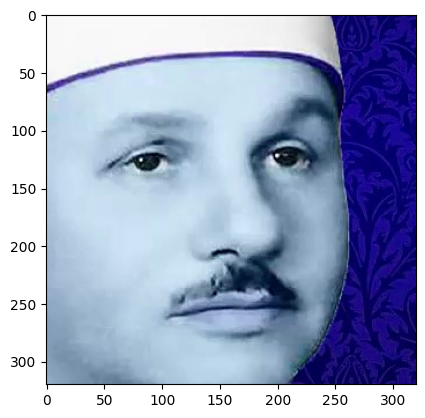

In [8]:
# Plotting an example of the face
path_to_face = 'data/__faces/banaa/banaa13.png'
plt.imshow(cv2.imread(path_to_face));

---
---

## Feature Engineering

In this phase, we apply signal processing to the images using the Wavelet Transform. Briefly, this technique decomposes each image into spatial-frequency components, allowing us to isolate and retain important visual details (such as eyes, nose, and other facial features) while discarding less informative low-frequency content.

- Note: Spatial frequency refers to how rapidly pixel values change across the image (i.e., over space). For ex, High spatial frequency represents sharp transitions (like edges of nose, eyes, lips, etc.).
- Special thanks to Stack Overflow for insights and examples.

In [11]:
def w2d(img, mode = 'haar', level = 1):
    imArray = img

    # Gray Scale
    imArray = cv2.cvtColor(imArray, cv2.COLOR_BGR2GRAY)
    imArray = np.float32(imArray)

    # Normalize pixel values to range [0, 1]
    imArray /= 255

    # Decompose the image using Discrete Wavelet transform -> returns (cA, (cH1, cV1, cD1), ..., (cHn, cVn, cDn))
    # cA: low frequencies
    # cH, cV, cD -> horizontal, vertical, and diagonal details
    coeffs = pywt.wavedec2(imArray, mode, level = level)

    # Removes low freq info
    coeffs_h = list(coeffs)
    coeffs_h[0] *= 0

    # Reconstructs the image
    imArray_h = pywt.waverec2(coeffs_h, mode)
    imArray_h *= 255
    imArray_h = np.uint8(imArray_h)

    return imArray_h

In [9]:
# Define path to cleaned images

# Dictionary to store images per shikh
shikh_faces = {}

# Walk through the directory tree
for dirpath, dirnames, images in os.walk(path_to_cleaned_faces):
    # Skip the root folder itself (it doesn't represent a shikh)
    if dirpath == path_to_cleaned_faces:
        continue

    shikh = os.path.basename(dirpath)
    shikh_faces[shikh] = [os.path.join(dirpath, img) for img in images]


In [11]:
shikh_faces

{'abdelbaset': ['data/__faces_after_manual_cleaning/abdelbaset\\abdelbaset1.png',
  'data/__faces_after_manual_cleaning/abdelbaset\\abdelbaset11.png',
  'data/__faces_after_manual_cleaning/abdelbaset\\abdelbaset12.png',
  'data/__faces_after_manual_cleaning/abdelbaset\\abdelbaset14.png',
  'data/__faces_after_manual_cleaning/abdelbaset\\abdelbaset15.png',
  'data/__faces_after_manual_cleaning/abdelbaset\\abdelbaset16.png',
  'data/__faces_after_manual_cleaning/abdelbaset\\abdelbaset17.png',
  'data/__faces_after_manual_cleaning/abdelbaset\\abdelbaset18.png',
  'data/__faces_after_manual_cleaning/abdelbaset\\abdelbaset19.png',
  'data/__faces_after_manual_cleaning/abdelbaset\\abdelbaset2.png',
  'data/__faces_after_manual_cleaning/abdelbaset\\abdelbaset20.png',
  'data/__faces_after_manual_cleaning/abdelbaset\\abdelbaset21.png',
  'data/__faces_after_manual_cleaning/abdelbaset\\abdelbaset22.png',
  'data/__faces_after_manual_cleaning/abdelbaset\\abdelbaset23.png',
  'data/__faces_after_

In [12]:
# Create classes (numbers) corresponding to shikh
shikh_classes = {}
count = 0
for img_dir in os.listdir(path_to_cleaned_faces):
    full_path = os.path.join(path_to_cleaned_faces, img_dir)

    if os.path.isdir(full_path):
        shikh_classes[img_dir] = count
        count += 1

shikh_classes

{'abdelbaset': 0, 'alaa': 1, 'banaa': 2, 'hossary': 3, 'meshary': 4}

In [15]:
# Extracting the features X and the target y
X, y = [], []

for shikh_name, training_imgs in shikh_faces.items():
    for training_img in training_imgs:
        # Read the image
        img = cv2.imread(training_img)
        if img is None:
            continue

        # Resizing and Getting features from the image
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img, 'db1', 5)
        scalled_img_har = cv2.resize(img_har, (32, 32))

        # Stacking both images to train the model on them
        combined_img = np.vstack(
            (scalled_raw_img.reshape(32*32*3, 1),
             scalled_img_har.reshape(32*32, 1))
        )
        X.append(combined_img)
        y.append(shikh_classes[shikh_name])

In [16]:
len(X), len(y)

(143, 143)

In [17]:
len(X[0]) # 32*32*32 + 32*32

4096

In [18]:
type(X)

list

In [19]:
# Turning both into numpy arrays
X = np.array(X).reshape(len(X), 4096).astype(float)
y = np.array(y)
X.shape, y.shape

((143, 4096), (143,))

---
---

## Model Development Process

In this phase, we are going to split the data into training and test sets, constuct several types of models and fitting them using the `GridSearch` and `CrossValidation` processes in order to get the best performance.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 0,
    stratify = y
)

---

In [21]:
X_train.shape, X_test.shape, len(y_train), len(y_test)

((114, 4096), (29, 4096), 114, 29)

#### Define Helpful Functions

In [23]:
def run_grid_search(estimator, model_parameters):
    '''
    Run GridSearchCV on a pipeline that includes preprocessing and the given model.
    
    Parameters:
        estimator:        The ML model (e.g., LogisticRegression)
        model_parameters: Dictionary of parameters (e.g., {'model__C': [...]})
    
    Returns:
        A fitted GridSearchCV object
    '''
    scoring = {
        'accuracy': 'accuracy',
        'precision': make_scorer(precision_score, average='macro', zero_division=0),
        'recall': make_scorer(recall_score, average='macro', zero_division=0),
        'f1': make_scorer(f1_score, average='macro', zero_division=0),
    }

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', estimator)
    ])

    model = GridSearchCV(
        estimator = pipe,
        param_grid = model_parameters,
        scoring = scoring,
        cv = 5,
        refit = 'accuracy',
        n_jobs = -1,
        verbose = 2
    )

    return model


In [23]:
# Extract GridSearchCV Results
def make_results(model_name: str, model_obj, evaluation_metric: str):
    '''
    Extracts GridSearchCV cross-validation scores and summarizes them in a table.
    
    Parameters:
        model_name (str): Name of the model
        model_obj: A fitted GridSearchCV object
        evaluation_metric (str): One of ['precision', 'recall', 'f1', 'accuracy']
  
    Returns:
        DataFrame: Summary table of scores
    '''
    
    metric_dict = {
        'precision' : 'mean_test_precision',
        'accuracy' : 'mean_test_accuracy',
        'recall' : 'mean_test_recall',
        'f1' : 'mean_test_f1'
    }

    # Get the GridSearchCV Results
    cv_results = pd.DataFrame(model_obj.cv_results_)

    # Best Estimator Results
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[evaluation_metric]].idxmax, :]

    # Scores
    f1 = round(best_estimator_results.mean_test_f1, 3)
    recall = round(best_estimator_results.mean_test_recall, 3)
    precision = round(best_estimator_results.mean_test_precision, 3)
    accuracy = round(best_estimator_results.mean_test_accuracy, 3)

    # Construct the DataFrame
    table = pd.DataFrame({
        'Model' : [model_name],
        'F1' : [f1],
        'Recall' : [recall],
        'Precision' : [precision],
        'Accuracy' : [accuracy]
    })

    return table

In [24]:
# Get Test Scores
def get_scores(model_name:str, model_obj, X_test, y_test):
    '''
    This function tests the model on the test data and returns the scores
    
    Parameters: 
        model_name (string):  How you want your model to be named in the output table
        model:                A fitted GridSearchCV object
        X_test:      numpy array of X_test data
        y_test:      numpy array of y_test data

    Returns
        table: pandas df contains the prediction metrics 
    '''

    # Get Predictions
    preds = model_obj.best_estimator_.predict(X_test)

    # Scores for multi-class predictions
    accuracy = round(accuracy_score(y_test, preds), 3)
    precision = round(precision_score(y_test, preds, average = 'macro', zero_division = 0), 3)
    recall = round(recall_score(y_test, preds, average = 'macro', zero_division = 0), 3)
    f1 = round(f1_score(y_test, preds, average = 'macro', zero_division = 0), 3)

    table = pd.DataFrame({
        'Model': [model_name],
        'Precision': [precision],
        'Recall': [recall],
        'F1': [f1],
        'Accuracy': [accuracy],
    })

    
    return table

In [25]:
# Function to save models
def save_model(path, model_object, saved_model_name : str):
    '''
    Function to save the trained model
    
    Parameters
        path:         path of folder where you want to save the pickle
        model_object: a model you want to pickle
        saved_model_name:      filename for how you want to save the model
    '''
    with open(path + saved_model_name + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [26]:
# Function to read models
def load_model(path, saved_model_name : str):
    '''
    Function to read the saved model
    
    Parameters
        path:             path of folder where you want to save the pickle
        saved_model_name: filename for how you want to save the model
    Returns
        model: the pickled model
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

---

#### Building Models

##### Logistic Regression Model

In [28]:
lr = LogisticRegression(random_state=0)


cv_params = {
    'model__C' : [0.01, 0.1, 1, 10],
    'model__penalty' : ['l2'],
    'model__solver' : ['lbfgs'],
    'model__max_iter' : [500, 700]
}

lr_cv = run_grid_search(lr, cv_params)

In [29]:
%%time

# lr_cv.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
CPU times: total: 453 ms
Wall time: 4.93 s


,estimator,Pipeline(step...om_state=0))])
,param_grid,"{'model__C': [0.01, 0.1, ...], 'model__max_iter': [500, 700], 'model__penalty': ['l2'], 'model__solver': ['lbfgs']}"
,scoring,"{'accuracy': 'accuracy', 'f1': make_scorer(f...ro_division=0), 'precision': make_scorer(p...ro_division=0), 'recall': make_scorer(r...ro_division=0)}"
,n_jobs,-1
,refit,'accuracy'
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [30]:
# Saving the model
save_path = 'models/'
save_model(save_path, lr_cv, 'LogisticRegression')

##### Random Forest Classifier

In [31]:
rf = RandomForestClassifier(random_state = 0)

cv_params = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__bootstrap': [True, False]
}

rf_cv = run_grid_search(rf, cv_params)

In [32]:
%%time

# rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
CPU times: total: 953 ms
Wall time: 10 s


,estimator,Pipeline(step...om_state=0))])
,param_grid,"{'model__bootstrap': [True, False], 'model__max_depth': [None, 10, ...], 'model__min_samples_leaf': [1, 2], 'model__min_samples_split': [2, 5], ...}"
,scoring,"{'accuracy': 'accuracy', 'f1': make_scorer(f...ro_division=0), 'precision': make_scorer(p...ro_division=0), 'recall': make_scorer(r...ro_division=0)}"
,n_jobs,-1
,refit,'accuracy'
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [33]:
# Save the model
save_model(save_path, rf_cv, 'RandomForest')

##### SVM Classifier

In [35]:
svc = svm.SVC(random_state = 0)

cv_params = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf'],
    'model__gamma': ['scale', 'auto'],
    'model__probability': [True]
}

svc_cv = run_grid_search(svc, cv_params)

In [36]:
%%time

# svc_cv.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: total: 250 ms
Wall time: 874 ms


,estimator,Pipeline(step...om_state=0))])
,param_grid,"{'model__C': [0.1, 1, ...], 'model__gamma': ['scale', 'auto'], 'model__kernel': ['linear', 'rbf'], 'model__probability': [True]}"
,scoring,"{'accuracy': 'accuracy', 'f1': make_scorer(f...ro_division=0), 'precision': make_scorer(p...ro_division=0), 'recall': make_scorer(r...ro_division=0)}"
,n_jobs,-1
,refit,'accuracy'
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [37]:
save_model(save_path, svc_cv, 'SVMClassifier')

##### Decision Tree Classifier

In [39]:
tree = DecisionTreeClassifier(random_state = 0)

cv_params = {
    'model__max_depth' : [4, 6],
    'model__min_samples_leaf' : [2, 5],
    'model__min_samples_split' : [2, 6],
}

tree_cv = run_grid_search(tree, cv_params)

In [40]:
%%time

# tree_cv.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
CPU times: total: 203 ms
Wall time: 726 ms


,estimator,Pipeline(step...om_state=0))])
,param_grid,"{'model__max_depth': [4, 6], 'model__min_samples_leaf': [2, 5], 'model__min_samples_split': [2, 6]}"
,scoring,"{'accuracy': 'accuracy', 'f1': make_scorer(f...ro_division=0), 'precision': make_scorer(p...ro_division=0), 'recall': make_scorer(r...ro_division=0)}"
,n_jobs,-1
,refit,'accuracy'
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [41]:
## Save the model
save_model(save_path, tree_cv, 'DecisionTree')

---

#### Models Comparison

In [43]:
saved_models = ['LogisticRegression', 'RandomForest', 'SVMClassifier', 'DecisionTree']
models = {}
for model in saved_models:
    models[model] = load_model(save_path, model)

In [54]:
for model in models.keys():
    print(f'Model: {model}')
    print(f'Best Parameters: {models[model].best_params_}')
    print(f'Best Croos Validation Score: {models[model].best_score_}')
    print('-' * 150)

Model: LogisticRegression
Best Parameters: {'model__C': 0.1, 'model__max_iter': 500, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best Croos Validation Score: 0.9201581027667984
------------------------------------------------------------------------------------------------------------------------------------------------------
Model: RandomForest
Best Parameters: {'model__bootstrap': False, 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Best Croos Validation Score: 0.8853754940711462
------------------------------------------------------------------------------------------------------------------------------------------------------
Model: SVMClassifier
Best Parameters: {'model__C': 0.1, 'model__gamma': 'scale', 'model__kernel': 'linear', 'model__probability': True}
Best Croos Validation Score: 0.9201581027667984
-------------------------------------------------------------------------------------------------------

In [55]:
# Making predictions 
test_scores = pd.DataFrame()

for model_name, model in models.items():
    model_result = get_scores(model_name, model, X_test, y_test)
    test_scores = pd.concat([test_scores, model_result], axis = 0)

In [56]:
test_scores = test_scores.sort_values(by = ['Accuracy', 'F1'], ascending = False).reset_index(drop = True)

In [57]:
test_scores

,Model,Precision,Recall,F1,Accuracy
0,LogisticRegression,0.951,0.920,0.930,0.931
1,SVMClassifier,0.950,0.920,0.927,0.931
2,RandomForest,0.853,0.767,0.767,0.793
3,DecisionTree,0.692,0.604,0.613,0.655


In [61]:
log_reg_clf = models['LogisticRegression']
svm_clf = models['SVMClassifier']

In [64]:
shikh_classes

{'abdelbaset': 0, 'alaa': 1, 'banaa': 2, 'hossary': 3, 'meshary': 4}

In [73]:
shikhs = []
for shikh, cls in shikh_classes.items():
    if cls in svm_clf.classes_:
        shikhs.append(shikh)

In [74]:
shikhs

['abdelbaset', 'alaa', 'banaa', 'hossary', 'meshary']

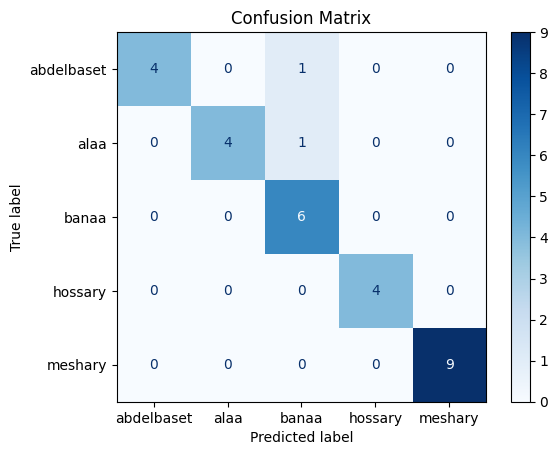

In [75]:
# Exploring SVM Confusion Matrix
y_pred = svm_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = shikhs)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

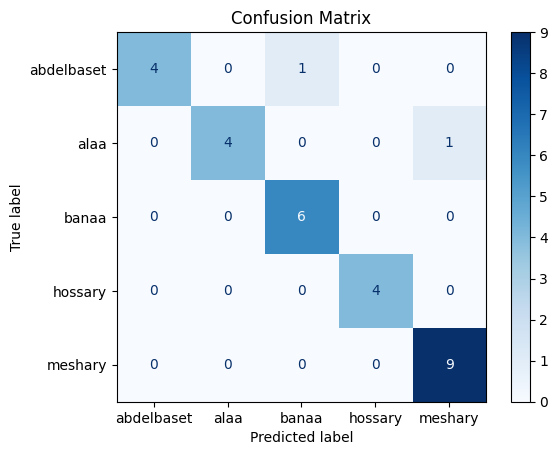

In [76]:
# Exploring log_reg Confusion Matrix
y_pred = log_reg_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusibon_matrix = cm, display_labels = shikhs)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [14]:
shikh_classes

{'abdelbaset': 0, 'alaa': 1, 'banaa': 2, 'hossary': 3, 'meshary': 4}

In [15]:
shikhs = {
    0 : {
        'arabic_name'  : 'عبدالباسط عبدالصمد',
        'english_name' : 'abdelbaset'
    },
    1 : {
        'arabic_name'  : 'علاء حامد',
        'english_name' : 'alaa'
    },
    2 : {
        'arabic_name'  : 'محمود علي البنا',
        'english_name' : 'banaa'
    },
    3 : {
        'arabic_name'  : 'محمود خليل الحصري',
        'english_name' : 'hossary'
    },
    4 : {
        'arabic_name'  : 'مشاري راشد العفاسي',
        'english_name' : 'meshary'
    },
}

In [ ]:
# Saving the classes 
with open('server/utils/shikhs.json', "w", encoding="utf-8") as f:
        json.dump(shikhs, f, indent = 4, ensure_ascii = False)

---
---

***ALHAMDULILLAH***